
Summary of the modeled results between 300.0 and 1200.0 nm

 Layer No. Material  Thickness (nm)  Jsc_Max (mA/cm^2)
         1      ITO             145               2.68
         2      ZnO             120               1.21
         3      PbS             250              24.04
         4       Au             100               1.45


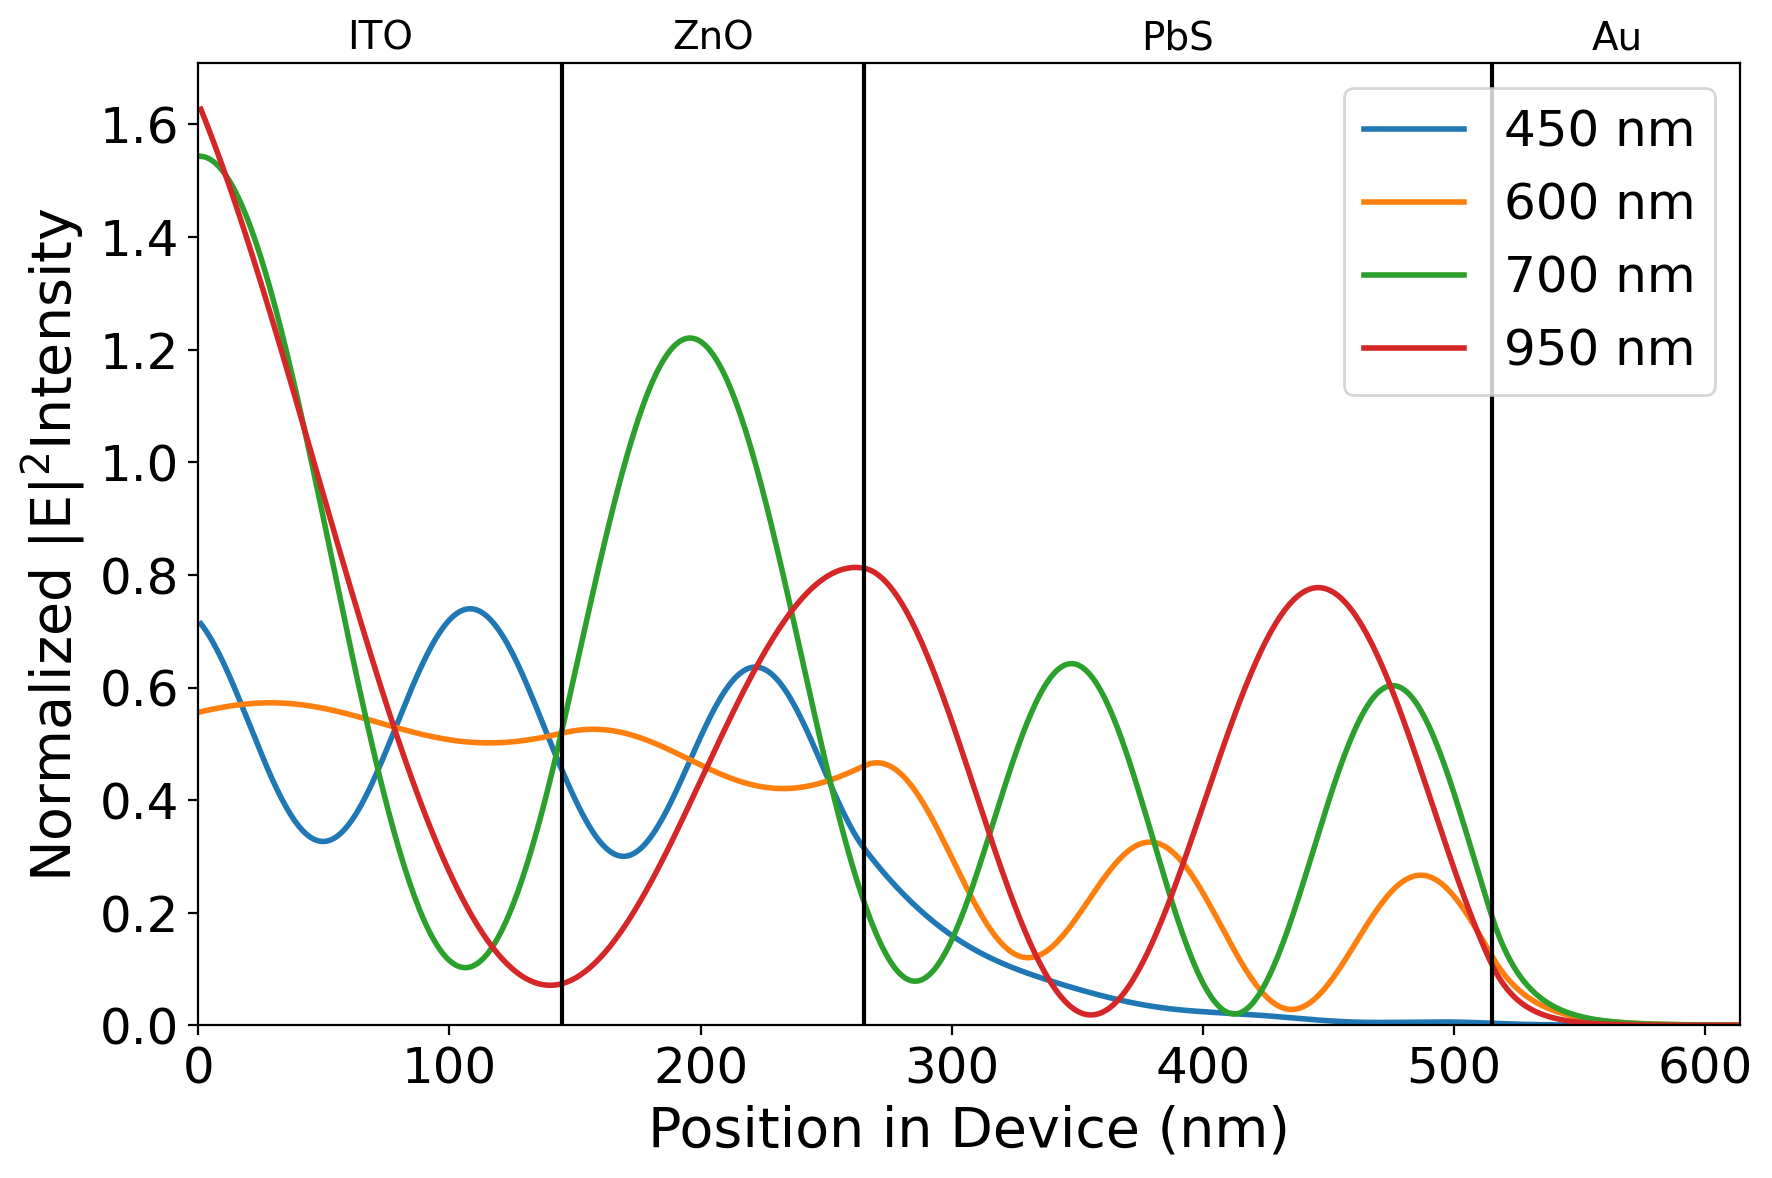

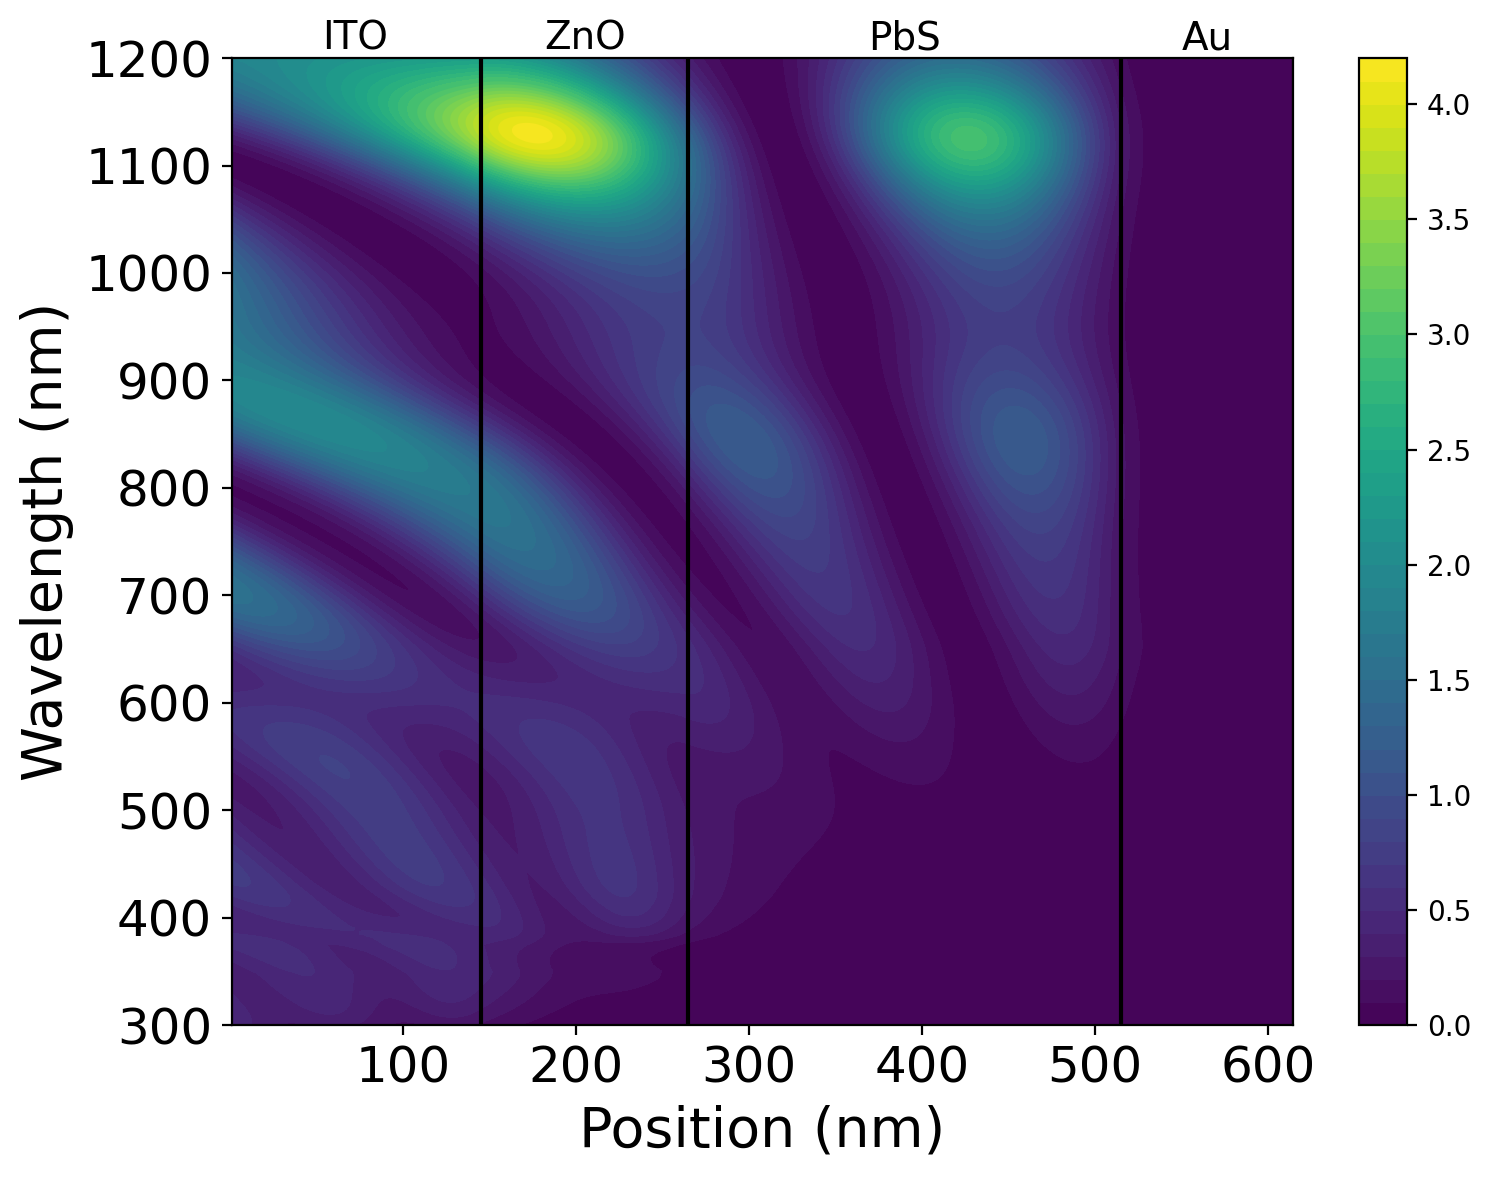

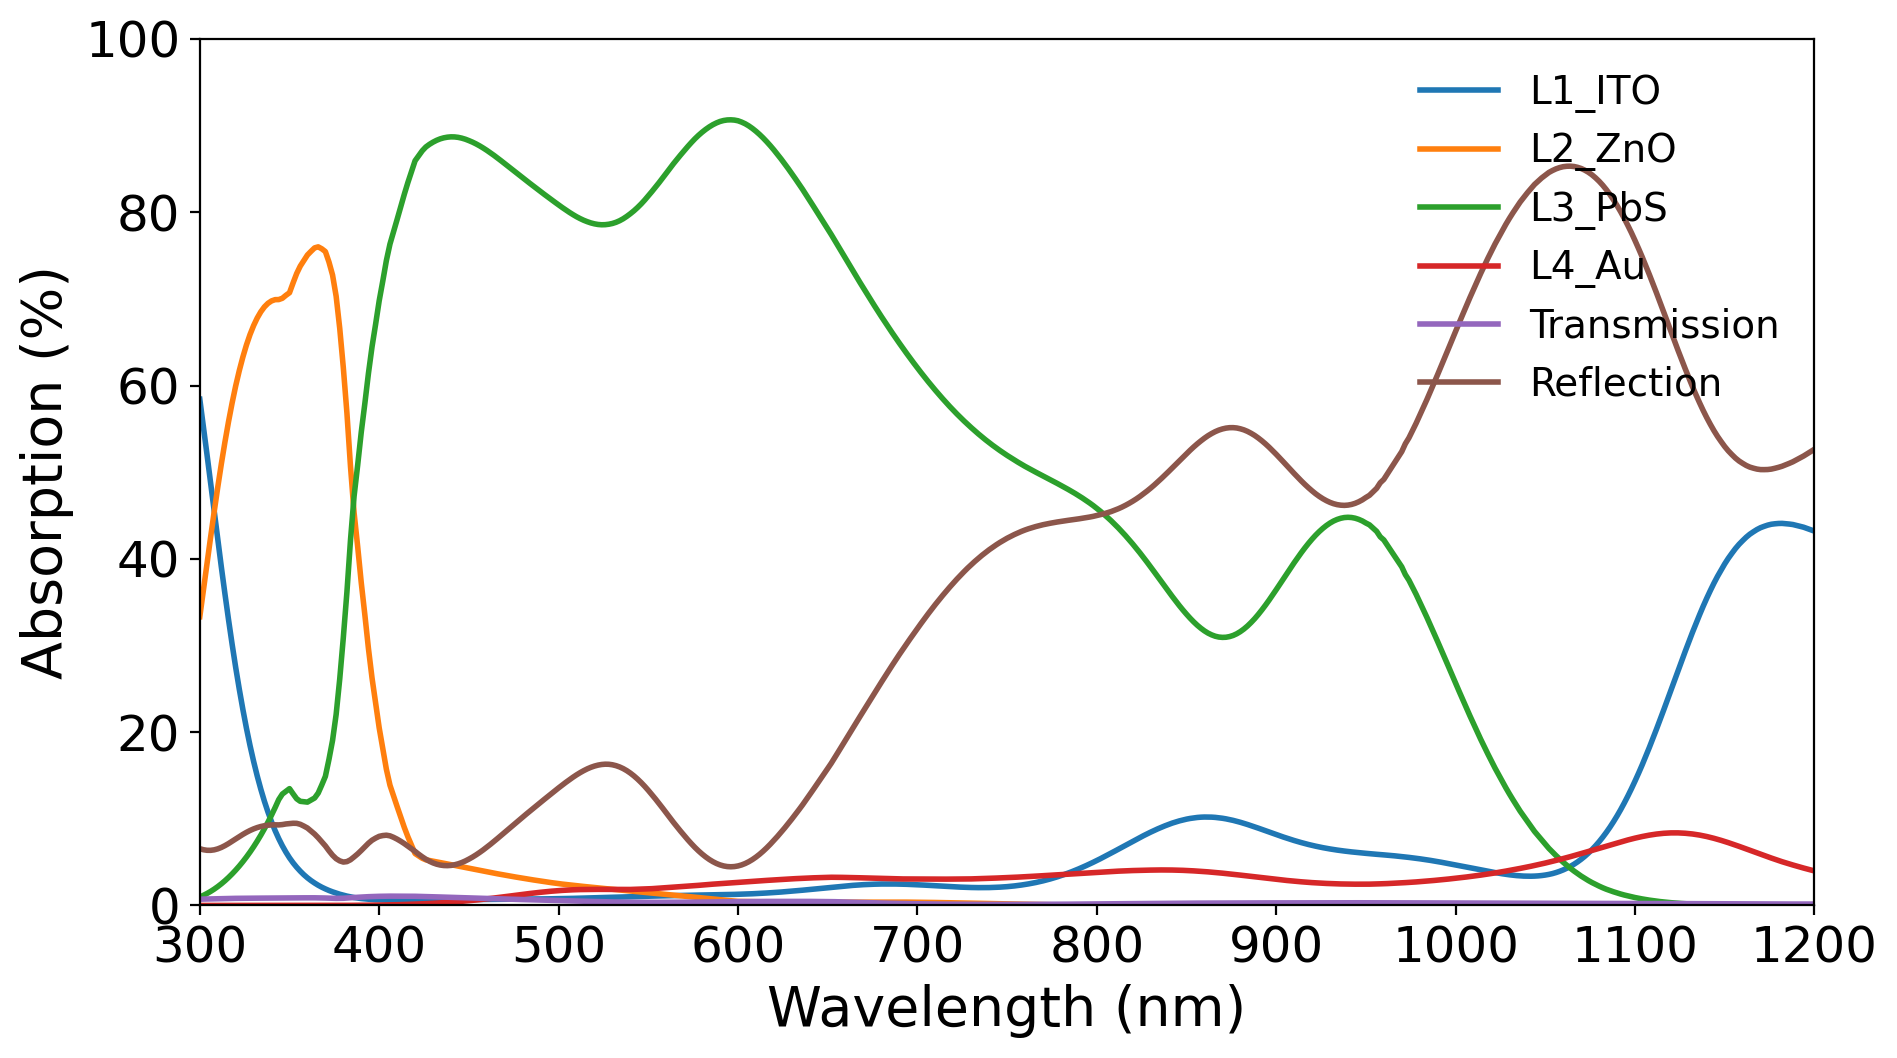

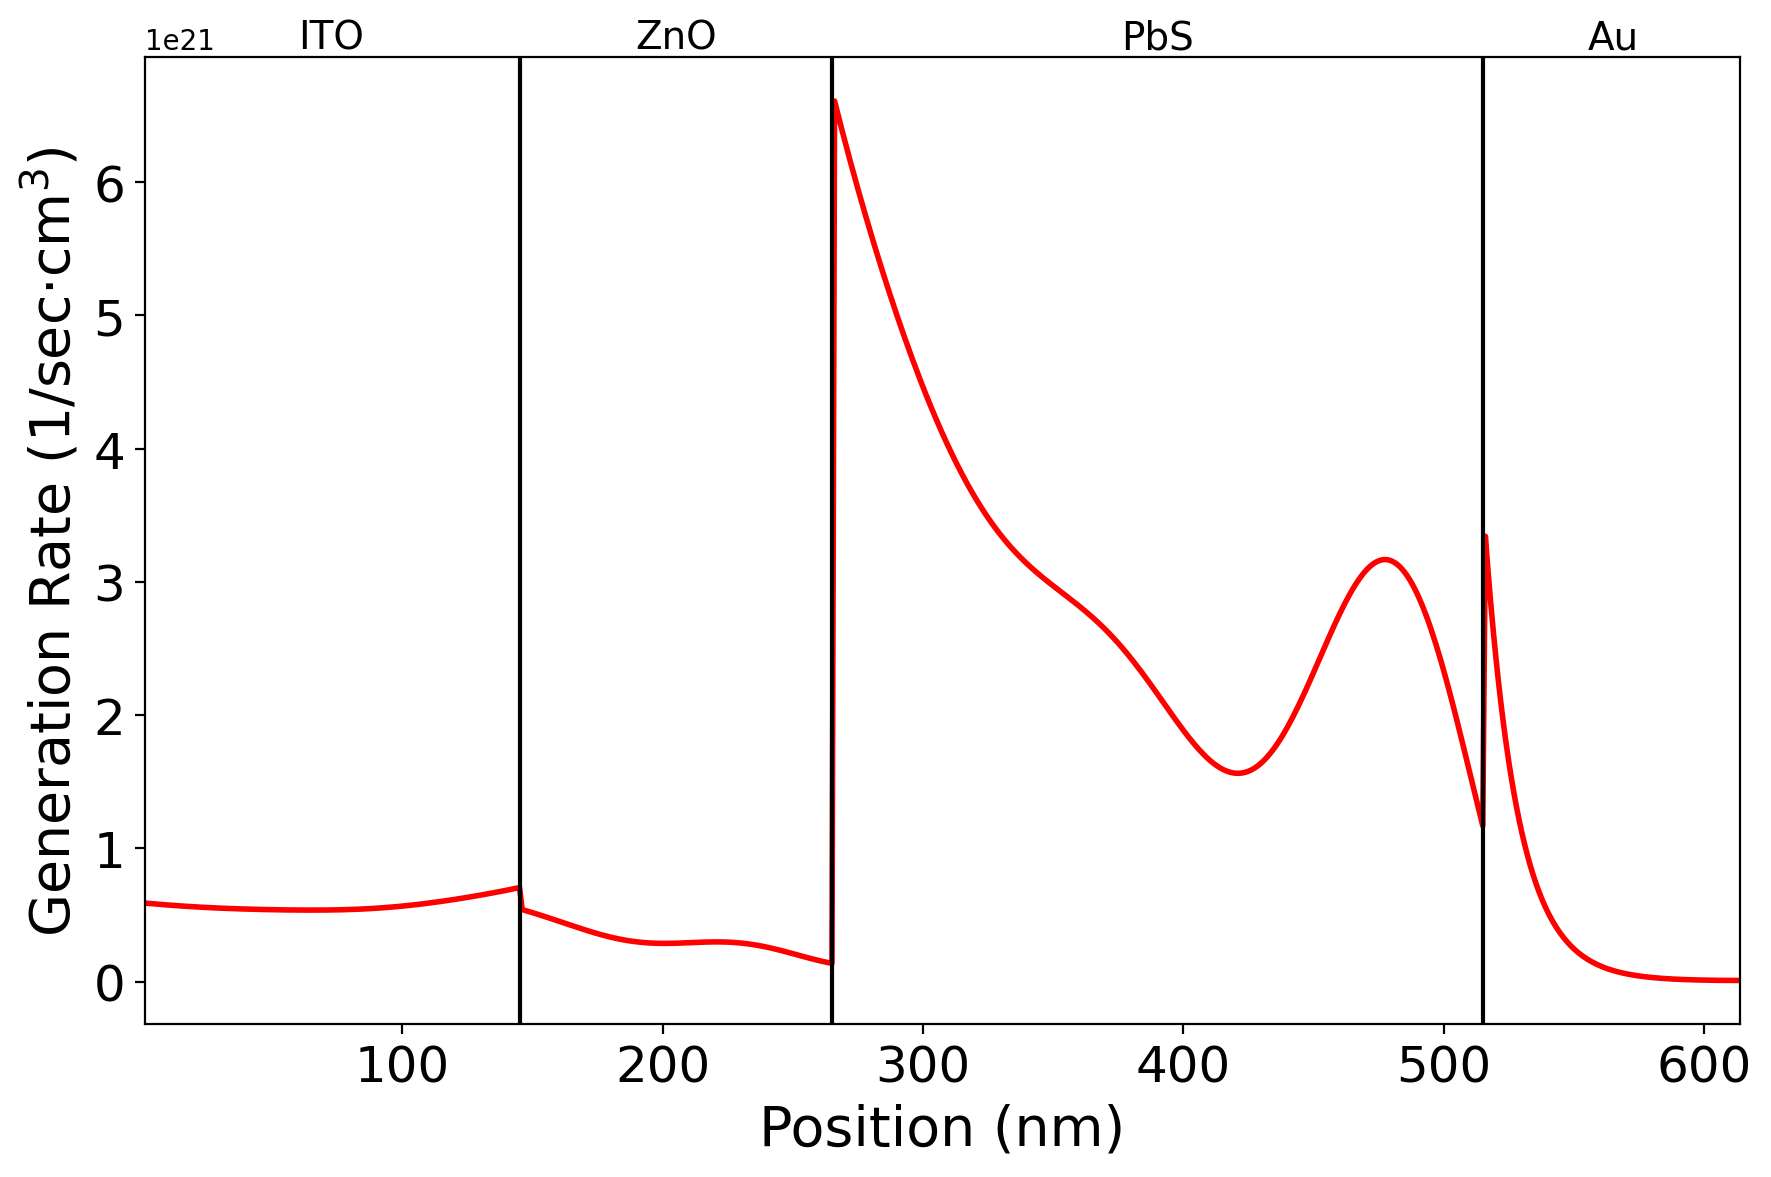

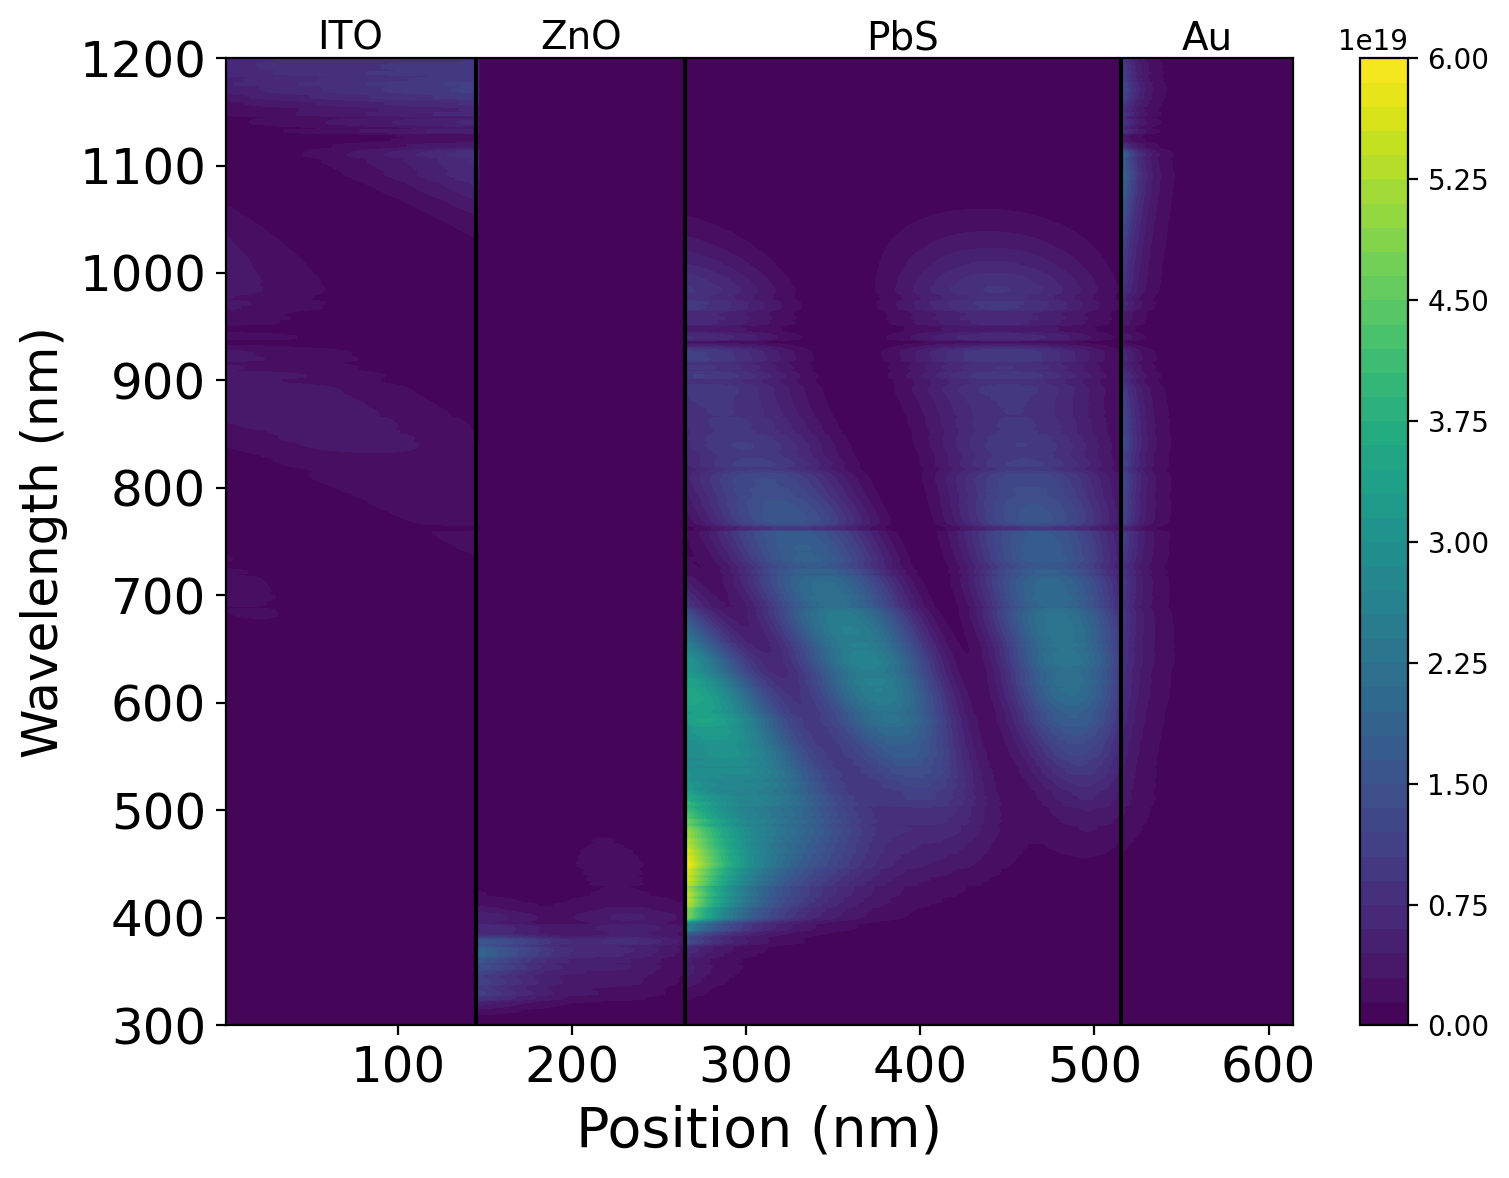

In [20]:
# -*- coding: utf-8 -*-
"""
@author: C. Marcus Chuang, 2015
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import bisect

import matplotlib as mpl
from matplotlib import style
%config InlineBackend.figure_format = 'retina'
mpl.rcParams.update(mpl.rcParamsDefault)

# Constants
h = 6.626e-34  # Js Planck's constant
c = 2.998e8  # m/s speed of light
q = 1.602e-19  # C electric charge


class OpticalModeling(object):
    def __init__(self, Device, libname, WLrange, WLstep=2.0, posstep=1.0,
                 plotWL=None, Solarfile="SolarAM15.csv"):
        """
        Initialize an OpticalMpdeling instance, load required data,
        and initialize required attributes
        """
        # layers (materials)
        self.layers = [Device[0][0]] + [mat[0] for mat in Device[1:]
                                        if float(mat[1]) > 0]
        # thickness; set the thickness of the substrate (first layer) to 0
        self.t = [0] + [mat[1] for mat in Device[1:] if float(mat[1]) > 0]
        self.t_cumsum = np.cumsum(self.t)
        # wavelength
        self.WL = np.arange(WLrange[0], WLrange[1] + WLstep, WLstep)
        self.WLstep = WLstep
        self.posstep = posstep
        # positions to evaluate field
        self.x_pos = np.arange(self.WLstep / 2.0, sum(self.t), self.posstep)
        # material i is in x_pos[x_ind[i-1]:xind[i]]
        self.x_ind = self.x_indice()
        self.AM15 = self.LoadSolar(Solarfile)  # load/reshape into desired WLs
        self.nk = self.Load_nk(libname)

        if plotWL is None:  # choose some WL with a gap of a multiple of 50
            wlrange = WLrange[1] - WLrange[0]
            mid = 50 * ((WLrange[1] + WLrange[0]) // 100)
            gap = 50 * ((wlrange - 50) // 150)
            plotWL = [mid - gap, mid, mid + gap] if gap != 0 else [mid]
        elif isinstance(plotWL, int) or isinstance(plotWL, float):
            plotWL = [plotWL]
        else:
            plotWL.sort()
        # choose valid values only
        self.plotWL = [w for w in plotWL if self.WL[0] <= w <= self.WL[-1]]

        # dp for calculating transfer matrices (used in CalE() )
        self.Imats = {}
        self.Lmats = {}

        """
        Below are some attributes in the instance. They don't have to be
        initialzed here, but doing so (setting them to None) makes it somewhat
        easier to keep track of the attributes
        """

        # ## These will be 2D numpy arrays, row: position; column: wavelength
        self.E = None  # E field
        self.AbsRate = None  # Absorption rate
        self.Gx = None  # carrier generation rate

        # ### These will be 1D numpy arrays, x: position
        self.Reflection = None  # Reflection 
        self.Transmission = None  # Transmission 

        # ### This will be a 2D pandas dataframe,
        # wavelegths vs absorption for each material
        self.Absorption = None  # Absorption

        self.Jsc = None  # 1D array, Max Jsc in each layer

    def RunSim(self, plotE=True, plotAbs=True, plotGen=True,
               saveFigE=False, saveFigAbs=False, saveFigGen=False,
               savename="Result", figformat="pdf"):
        """
        Run the simulation. This method would complete all the caculation.
        """
        self.Cal_Imat_Lmats()
        S, Sp, Sdp = self.CalS()
        self.CalE(S, Sp, Sdp)
        self.CalAbs()
        self.CalGen()
        if saveFigE or saveFigAbs or saveFigGen:
            path = os.getcwd()
            outdir = os.path.normpath(path + os.sep + "Results")
            if not os.path.exists(outdir):
                os.makedirs(outdir)
        if plotE:
            self.PlotE(savefig=saveFigE, savename=savename,
                       figformat=figformat)
        if plotAbs:
            self.PlotAbs(savefig=saveFigAbs, savename=savename,
                         figformat=figformat)
        if plotGen:
            self.PlotGen(savefig=saveFigGen, savename=savename,
                         figformat=figformat)
        return None

    def SaveData(self, savename="Result",
                 saveAbs=True, saveE=False, saveGen=False):
        """
        Save the results as .csv file in a sub folder called "Results"
        default: save absorption only

        savename: prefix of the file name, default is "Result"
        saveAbs : save Absorption
        saveE : save E-field self.E (position vs wavelength)
        saveGen : save generation profile self.Gx  (position vs wavelength)
        """

        if saveE or saveAbs or saveGen:
            path = os.getcwd()
            outdir = os.path.normpath(path + os.sep + "Results")
            if not os.path.exists(outdir):
                os.makedirs(outdir)

        if saveE:
            df_E = pd.DataFrame(abs(self.E**2))
            df_E.index = self.x_pos
            pE = os.path.normpath(outdir + os.sep + savename + "_Efield.csv")
            df_E.to_csv(path_or_buf=pE, header=self.WL)
        if saveGen:
            df_Gen = pd.DataFrame(self.Gx)
            df_Gen.index = self.x_pos
            pG = os.path.normpath(outdir + os.sep + savename + "_Gen.csv")
            df_Gen.to_csv(path_or_buf=pG, header=self.WL)
        if saveAbs:
            df_Abs = pd.DataFrame(self.Absorption)
            df_Abs["Transmission"] = self.Transmission
            df_Abs["Reflection"] = self.Reflection
            df_Abs.index = self.WL
            pA = os.path.normpath(outdir + os.sep + savename +
                                  "_Absorption.csv")
            df_Abs.to_csv(path_or_buf=pA)

        return None

    def LoadSolar(self, Solarfile):
        Solar = pd.read_csv(Solarfile, header=0)
        AM15 = np.interp(self.WL, Solar.iloc[:, 0], Solar.iloc[:, 1])
        return AM15  # mW/cm2 nm

    def Load_nk(self, libname):
        # load data
        nk = pd.read_csv(libname, header=0)

        if 'Wavelength (nm)' not in nk:
            errtxt = "Library MUST contains a column called 'Wavelength (nm)'"
            raise ValueError(errtxt)

        nkWL = nk["Wavelength (nm)"]
        if self.WL[-1] > max(nkWL) or self.WL[0] < min(nkWL):
            raise ValueError(
                "Input wavelength range is not valid.\n" +
                "It should be within the range of the wavelength in the " +
                "refraction index library")

        # Initialize a dict d_nk  (key, val) = (mater: complex nk)
        # key is the name of the material, val is the complex value of nk
        # (indexing in np array is faster than pandas dataframe)
        d_nk = {}
        d_nk["WL"] = self.WL
        d_nk["Air"] = np.array([1] * len(self.WL))
        # interp n,k to the desired WL range and store them in nk
        for mater in self.layers:
            if mater not in d_nk:
                if mater + "_n" not in nk or mater + "_n" not in nk:
                    raise ValueError("Invalid input : \nCan't find the " +
                      "refraction indices for material '{}'\n".format(mater) +
                      "The library file must contain the these two columns\n" +
                      "'{0}_n' and '{0}_k'".format(mater))
                n = np.interp(self.WL, nk["Wavelength (nm)"], nk[mater + "_n"])
                k = np.interp(self.WL, nk["Wavelength (nm)"], nk[mater + "_k"])
                d_nk[mater] = n + 1j * k

        return d_nk

    def x_indice(self):
        """
        return a list of indice "x_ind" for use in x_pos
        material i corresponds to the indices range
        [x_ind[i-1], xind[i]) in x_pos
        Note: the first layer is glass and is excluded in x_pos
        """

        return [bisect.bisect_right(self.x_pos, self.t_cumsum[i])
                for i in range(len(self.t))]

    def CalE(self, S, S_prime, S_dprime):
        """
        Calculate incoherent power transmission through substrate
        T = |4*n1*n2 / (n1+n2)^2| , R = |((n1-n2)/(n1+n2))^2|
        It would calculate and update
        1. The electric field in the device stack (self.E)
        2. The reflection (self.Reflection)
        """

        subnk = self.nk[self.layers[0]]

        T_glass = abs(4 * 1 * subnk / (1 + subnk)**2)
        R_glass = abs(((1 - subnk) / (1 + subnk))**2)

        # Calculate transfer matrices and field at each wavelength and position
        self.E = np.zeros([len(self.x_pos), len(self.WL)], dtype=complex)

        R = (abs(S[:, 1, 0] / S[:, 0, 0]))**2
        T = abs(2.0 / (1 + self.nk[self.layers[0]])) / (1 - R_glass * R)**0.5

        layers = self.layers + ['Air']
        for matind in range(1, len(layers) - 1):  # last one is 'air', ignore
            mater = layers[matind]
            for i, w in enumerate(self.WL):
                xi = 2.0 * np.pi * self.nk[mater][i] / w
                dj = self.t[matind]

                # x: distance from previous layer
                x = (self.x_pos[self.x_ind[matind - 1]:self.x_ind[matind]] -
                     self.t_cumsum[matind - 1])

                Sp, Sdp = S_prime[matind][i], S_dprime[matind][i]

                numerator = (
                    Sdp[0, 0] * np.exp(complex(0, -1.0) * xi * (dj - x)) +
                    Sdp[1, 0] * np.exp(complex(0, 1.0) * xi * (dj - x)))

                denom = (
                    Sp[0, 0] * Sdp[0, 0] * np.exp(complex(0, -1.0) * xi * dj) +
                    Sp[0, 1] * Sdp[1, 0] * np.exp(complex(0, 1.0) * xi * dj))

                l, r = self.x_ind[matind - 1], self.x_ind[matind]
                self.E[l:r, i] = T[i] * numerator / denom

        self.Reflection = R_glass + T_glass**2 * R / (1 - R_glass * R)

        return None

    def Cal_Imat_Lmats(self):
        Imats, Lmats = self.Imats, self.Lmats
        layers = self.layers + ["Air"]
        # precalculate all the required Imat and Lmat
        for matind in range(len(layers)-1):
            mater, nex = layers[matind], layers[matind+1]
            if matind not in Lmats:
                Lmats[matind] = self.L_mat(matind)
            if (mater, nex) not in Imats:
                Imats[(mater, nex)] = self.I_mat(mater, nex)
        return

    def CalS(self):
        '''
        calculate S, S_prime, and S_dprime
        S = S' * L  * S"   for any j j    j    j
        i = j-1
        S'[j]  = [  product  ( I      * L    )  ]   * I(j>0)         
        i = 0      i,i+1    i+1           j, j+1

        '''

        Imats, Lmats = self.Imats, self.Lmats
        nWL = len(self.WL)
        S_prime, S_dprime = {}, {}

        layers = self.layers + ["Air"]

        # calculate S_prime and S
        S = np.array([np.eye(2, dtype=complex) for _ in range(nWL)])
        for matind in range(1, len(layers)):
            pre, mater = layers[matind - 1], layers[matind]
            for i in range(nWL):
                S[i] = S[i].dot(Lmats[matind - 1][i])
                S[i] = S[i].dot(Imats[(pre, mater)][i])
            S_prime[matind] = np.copy(S)

        S_dprime[len(layers)-2] = Imats[(layers[-2], layers[-1])]

        for matind in range(len(layers)-3, 0, -1):
            mater, nex = layers[matind], layers[matind + 1]
            tmp = np.copy(S_dprime[matind + 1])
            for i in range(nWL):
                tmp[i] = np.dot(Lmats[matind+1][i], tmp[i])
                tmp[i] = np.dot(Imats[(mater, nex)][i], tmp[i])
            S_dprime[matind] = tmp

        return S, S_prime, S_dprime

    def CalAbs(self):
        """
        Calculate normalized intensity absorbed /cm3-nm at each position and
        wavelength as well as the total reflection expected from the device
        """
        # Absorption coefficient in cm^-1 (JAP Vol 86 p.487 Eq 23)
        a = pd.DataFrame()
        for mater in self.layers[1:]:
            if mater not in a:
                a[mater] = 4 * np.pi * self.nk[mater].imag / (self.WL * 1e-7)

        # initialize Absrate with E^2, multiply nk later
        self.AbsRate = abs(self.E)**2
        self.Absorption = pd.DataFrame()  # initialize Absorption
        for matind in range(1, len(self.t)):
            mater = self.layers[matind]
            posind = self.x_ind[matind-1], self.x_ind[matind]
            mlabel = "L" + str(matind) + "_" + mater
            self.AbsRate[posind[0]:posind[1]] *= (
                a[mater] * np.real(self.nk[mater])).values
            self.Absorption[mlabel] = (
                np.sum(self.AbsRate[posind[0]:posind[1]], 0) *
                self.posstep * 1e-7)
        self.Transmission = 1.0 - np.sum(self.Absorption, 1) - self.Reflection

        return None

    def CalGen(self):
        """
        Calculate generation rates as a function of position in the device
        and calculates Jsc (in mA/cm^2)
        """
        # Energy dissipation mW/cm3-nm at each position and wavelength
        # (JAP Vol 86 p.487 Eq 22)
        if self.AbsRate is None:
            self.CalAbs()
        Q = self.AbsRate * self.AM15
        self.Gx = Q * 1e-12 / (h * c) * self.WL

        Gx_x = [np.sum(self.Gx[self.x_ind[i-1]:self.x_ind[i]])
                for i in range(1, len(self.layers))]
        self.Jsc = np.array(Gx_x) * self.WLstep * self.posstep * q * 1e-4

        return None

    def PlotE(self, savename="Result", savefig=False, figformat='pdf', 
              cmap=None):
        """
        Plot electric field intensity |E|^2 vs position in the device.
        It would generate 2 plots:
        1. A contour map of E field vs wavelength vs position
        2. A E-field vs position plot for the selected wavelengths specified
           in the input plotWL.

        if savefig is set to True, it would save it in a sub folder 'Results'
        savename : prefix of the saved figure
        figformat : the figure format, use 'png' or 'pdf'

        """
        savename += "_Fig_Efield"
        fig1 = plt.figure("E field for selected WL", figsize=(9, 6))

        # fig1 = plt.figure(1)
        plt.clf()
        ax1 = fig1.add_subplot(111)
        ax1.set_ylabel('Normalized |E|$^2$Intensity', size=20)
        ax1.set_xlabel('Position in Device (nm)', size=20)
        ax1.tick_params(labelsize=18)

        E2 = abs(self.E**2)
        for i, w in enumerate(self.plotWL):
            label = "%s nm" % w
            # find the index closest to the desired wavelength
            # can use bisect actually
            xind = min(range(len(self.WL)), key=lambda x: abs(self.WL[x] - w))
            ax1.plot(self.x_pos, E2[:, xind], label=label, linewidth=2)
        ax1.set_ylim(ymin=0)

        # E-field, contour
        fig2 = plt.figure("E-field", figsize=(8, 6))
        plt.clf()
        X, Y = np.meshgrid(self.x_pos, self.WL)
        ax2 = fig2.add_subplot(111)
        ax2.set_ylabel('Wavelength (nm)', size=20)
        ax2.set_xlabel('Position (nm)', size=20)
        ax2.set_xlim(self.x_pos[0], self.x_pos[-1])
        ax2.set_ylim(self.WL[0], self.WL[-1])

        # ax2.contourf(X,Y,E2.T, 50, lw=0.1)
        # CS = ax2.contourf(X, Y, E2.T, 50, cmap=plt.cm.jet)
        CS = ax2.contourf(X, Y, E2.T, 50, cmap=cmap)
        for c in CS.collections:  # avoid white gaps when converting to pdf
            c.set_edgecolor("face")
        ax2.tick_params(labelsize=18)
        fig2.colorbar(CS)
        # fig2.suptitle('Normalized E-field Intensity',
        #                fontsize=20)

        # layer bars
        for matind in range(2, len(self.layers)+1):
            ax1.axvline(self.t_cumsum[matind-1], color="black")
            ax2.axvline(self.t_cumsum[matind-1], color="black")
            x_text = (self.t_cumsum[matind-2] +
                      self.t_cumsum[matind-1]) / 2.0
            ax1.text(x_text, ax1.get_ylim()[1] + 0.01, self.layers[matind-1],
                     size=14, va="bottom", ha="center")
            ax2.text(x_text, ax2.get_ylim()[1] + 0.01, self.layers[matind-1],
                     size=14, va="bottom", ha="center")
        ax1.set_xlim(0, max(self.x_pos))
        ax1.legend(loc='upper right', fontsize=18)

        fig1.tight_layout()
        fig2.tight_layout()

        if savefig:
            outdir = os.path.normpath(os.getcwd() + os.sep + "Results")
            fname1 = os.path.normpath(outdir + os.sep + savename +
                                      "_selectedWL." + figformat)
            fname2 = os.path.normpath(outdir + os.sep + savename +
                                      "." + figformat)

            fig1.savefig(fname1, transparent=False)
            fig2.savefig(fname2, transparent=False)

        return None

    def PlotAbs(self, savename="Result", savefig=False, figformat='pdf'):
        """
        Plot normalized intensity absorbed /cm3-nm at each position and
        wavelength as well as the reflection and transmission
        """
        savename += "_Fig_Absorption"
        fig3 = plt.figure("Absorption", (9.6, 5.4))  # 16:9
        plt.clf()
        ax3 = fig3.add_subplot(111)
        ax3.set_ylabel('Absorption (%)', size=20)
        ax3.set_xlabel('Wavelength (nm)', size=20)
        ax3.tick_params(labelsize=18)

        for matind in range(1, len(self.t)):
            mater = self.layers[matind]
            mlabel = "L" + str(matind) + "_" + mater
            ax3.plot(self.WL, 100.0 * self.Absorption[mlabel],
                     label=mlabel, linewidth=2)
        ax3.plot(self.WL, 100.0 * self.Transmission,
                 label="Transmission", linewidth=2)
        ax3.plot(self.WL, 100.0 * self.Reflection,
                 label="Reflection", linewidth=2)
        ax3.legend(loc='upper right', fontsize=14, frameon=False)

        ax3.set_ylim(ymin=0, ymax=100.0)
        ax3.set_xlim(xmin=self.WL[0], xmax=self.WL[-1])

        plt.tight_layout()

        if savefig:
            outdir = os.path.normpath(os.getcwd() + os.sep + "Results")
            fname3 = os.path.normpath(outdir + os.sep + savename +
                                      "." + figformat)
            fig3.savefig(fname3, transparent=False)

        return None

    def PlotGen(self, savename="Result", savefig=False, figformat='pdf',
                cmap=None):
        """
        Plot generation rate as a function of position in the device
        """
        savename += "_Fig"
        Gx_pos = np.sum(self.Gx, 1)
        fig4 = plt.figure("Generation Rate", figsize=(9, 6))
        fig4.clf()
        ax4 = fig4.add_subplot(111)
        ax4.set_xlabel('Position (nm)', size=20)
        ax4.set_ylabel('Generation Rate (1/sec$\cdot$cm$^3$)', size=20)
        ax4.plot(self.x_pos, Gx_pos, linewidth=2, color="r")

        fig5 = plt.figure("Carrier Generation (Photon Absorption) Rate",
                          figsize=(8, 6))
        fig5.clf()
        ax5 = fig5.add_subplot(111)
        ax5.set_ylabel('Wavelength (nm)', size=18)
        ax5.set_xlabel('Position (nm)', size=20)
        X, Y = np.meshgrid(self.x_pos, self.WL)

        ax4.tick_params(labelsize=18)
        ax5.tick_params(labelsize=18)
        ax4.set_xlim(self.x_pos[0], self.x_pos[-1])
        ax5.set_xlim(self.x_pos[0], self.x_pos[-1])
        ax5.set_ylim(self.WL[0], self.WL[-1])

        # ax5.contourf(X, Y, self.Gx.T, 50)
        # CS = ax5.contourf(X, Y, self.Gx.T, 50, cmap=plt.cm.jet)
        CS = ax5.contourf(X, Y, self.Gx.T, 50, cmap=cmap)
        for c in CS.collections:  # avoid white gaps when converting to pdf
            c.set_edgecolor("face")
        ax5.tick_params(labelsize=18)
        fig5.colorbar(CS)
        # fig5.suptitle('Photon Absorption Rate (1/sec$\cdot$nm$\cdot$cm$^3$)',
        #               fontsize=16, fontweight='bold')

        for matind in range(2, len(self.layers)+1):
            ax4.axvline(self.t_cumsum[matind-1], color="black")
            ax5.axvline(self.t_cumsum[matind-1], color="black")

            x_text = (self.t_cumsum[matind-2] +
                      self.t_cumsum[matind-1]) / 2.0

            ax4.text(x_text, ax4.get_ylim()[1] + 0.01, self.layers[matind - 1],
                     size=14, va="bottom", ha="center")
            ax5.text(x_text, ax5.get_ylim()[1] + 0.01, self.layers[matind - 1],
                     size=14, va="bottom", ha="center")
        fig4.tight_layout()
        fig5.tight_layout()

        if savefig:
            outdir = os.path.normpath(os.getcwd() + os.sep + "Results")
            fname4 = os.path.normpath(
                outdir + os.sep + savename + "_Gen_position_." + figformat)
            fname5 = os.path.normpath(
                outdir + os.sep + savename +
                "_CarrierGeneration(PhotonAbs)Rate." + figformat)

            fig4.savefig(fname4, transparent=False)
            fig5.savefig(fname5, transparent=False)

        return None

    def JscReport(self):
        '''
        OM: Optical Modeling object
        print Jsc report: layer/materials/thickness/Jsc_max(@100% IQE)
        return Jsc report (a pd dataframe)
        '''
        self.JscData = pd.DataFrame()
        self.JscData["Layer No."] = range(1, len(self.layers))
        self.JscData["Material"] = self.layers[1:]
        self.JscData["Thickness (nm)"] = self.t[1:]
        self.JscData["Jsc_Max (mA/cm^2)"] = np.round(self.Jsc, 2)

        print("\nSummary of the modeled results between " +
              "{0:.1f} and {1:.1f} nm\n".format(self.WL[0], self.WL[-1]))

        print(self.JscData.to_string(index=False))
        return self.JscData

    def I_mat(self, mat1, mat2):
        """
        Calculate the transfer matrix I for Reflection and Transmission
        at an interface between two materials.
        mat1, mat2: name of the materials
        return I, a  numpy array with shape len(self.WL)x2x2
        I[i] is the transfer matrix at wavelength self.WL[i]

        I[i] = 1/T[i] *  [ [    1,  R[i] ]
                           [ R[i],     1 ] ]
        """
        n1s, n2s = self.nk[mat1], self.nk[mat2]  # complex dielectric constants
        R = (n1s-n2s) / (n1s+n2s)
        T = 2.0 * n1s / (n1s+n2s)
        I = np.array([[[1.0, R[i]], [R[i], 1.0]] / T[i]
                      for i in range(R.shape[0])])
        return I

    def L_mat(self, matind):
        """
        Calculate the propagation matrix L, through a material
        matind: index of the material
        material name : mat = self.layers[matind]
        thickness     : d   = self.t[matind]
        complex dielectric constants:  self.nk[mat]

        return L, a numpy array with shape len(self.WL)x2x2 array
        L[i] is the propogation matrix at wavelength self.WL[i]

        L[i] = [ [ exp(-x*d),        0 ]
                 [         0, exp(-x*d)] ]
        where x = n*cos(phi)* 2*(pi)/(lambda),
        (n:complex, phi:incident angle, here phi= 0
        """

        mat, d = self.layers[matind], self.t[matind]  # d: thickness
        x = 2.0 * (np.pi) * self.nk[mat] / self.WL
        L = np.array([[[np.exp((-1j) * x[i] * d), 0],
                       [0, np.exp(1j * x[i] * d)]]
                      for i in range(x.shape[0])])
        return L


if __name__ == "__main__":

    Demo = True  # set Demo to True to run an example simulation

    if Demo:
        Device = [
                  ("Glass"  , 100),
                  ("ITO"    , 145),
                  ("ZnO"    , 120),
                  ("PbS"    , 250),
                  ('Au', 100)
                 ]
        libname = "Index_of_Refraction_library_Demo.csv"
        Solarfile = "SolarAM15.csv"
        OM = OpticalModeling(Device, libname=libname,
                             WLrange=(300, 1200),
                             plotWL=[450, 600, 700, 950])
        OM.RunSim()
        Jsc = OM.JscReport()
        plt.show()